This notebook addresses multivariate analysis for data published in [Helmke and Heald, 2014](http://jcb.rupress.org/content/206/3/385.full). All images were passed through the pipeline reported here. In this notebook, we have focused on demonstrating, how one can quickly pick most interesting variables from a multivariate data set. To run the notebook with your own input, just substitute the respective paths.

####Table of contents:   
1. Data folder.     
2. Feature description and pre-processing  
    * meta data, object location, missing values
3. Feature selection and engineering    
4. Predictive models    
5. Unsupervised models    



Non-standard columns: **'Meta'** columns, **'locator'** columns, **'NA'** columns, **Euclidian distance** (engineered), **Zernike polynomials**, **children**, **parents**. 

#I. Data folder

In [1]:
!ls ../../A_PAPER2_PIPELINE

A_TECH_PAPER             Partial Datasets         STG8_CSF_Mixing
Colors.txt               Presentation:Figures:etc TPX2
Complete Dataset         STG8


In [2]:
!ls ../../A_PAPER2_PIPELINE/TPX2/ 

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
DefaultDB.db                 MyExpt_FilteredChromatin.csv
DefaultDB_MyExpt.properties  MyExpt_FilteredSpindles.csv
DefaultOUT.h5                MyExpt_Image.csv
MyExpt_Chromatin.csv         MyExpt_PreSpindles.csv
MyExpt_Experiment.csv        MyExpt_Spindles.csv


In [3]:
!head -n3 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Chromatin.csv 

The file above specifies the location of objects.

In [4]:
!head ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Experiment.csv 







Pipeline_Pipeline,"CellProfiler Pipeline: http://www.cellprofiler.org
Version:3
DateRevision:20140723173957
GitHash:6c2d896


In [5]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredChromatin.csv

The file below is the actual file of interest.

In [6]:
!head ../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv

It has 203 columns, though not all of them are actual measurements.

In [7]:
!head -n3 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv | awk 'BEGIN{FS=","}{print NF}'

203
203
203


In [8]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Image.csv

In [9]:
!head -n 2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Image.csv | awk 'BEGIN{FS=","} {print NF}' 

1012
1012


In [10]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_PreSpindles.csv

In [11]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Spindles.csv

#II. Feature description and pre-processing    
Important things to consider:   
- missing data    
- types of variables (classes)    
- types of distributions (moments of distribution) and necessary transformations (Box-Cox)
- collinearity and multicollinearity (PCA, VIF, )

#Feature selection and engineering
There are several ways to select best features. One thing that one has to take into consideration is a phenomenon called multicollinearity, in which we have near linear relationships in explanatory variables, which leads to unstable parameter estimates. It may not necessarily affect accuracy of a predictive model, but it will affect analysis of the features that contribute to its performance (we will compare that). We would like to identify these variables, as, scientifically, we might actually be interested in these correlations (although some may be a result of mathematical necessity). The added benefit is that, once we know them, we can take care of them before we run a classification algorithm.      
       
Some of the options one can consider: 
* removing features with lowest variance     
* ranking features according to the KS test p-value between conditions    
* performing feature selection based on the value of variance inflation factor    
* factor analysis (classification of variables)
* selecting variables based on the Bayesian classification model (sigmoid function) followed by Fischer exact test for each feature (univariate feature selection)     
* Kruskall-Wallis
* stepwise discriminant analysis
* sequential forward search (SFS)
* sequential floating forward search (SFFS)
* classifier supported recursive feature elimination 

##IIa. Variable types and missing values

**First**, we load all necessary packages.

In [12]:
%load_ext rpy2.ipython
%matplotlib inline

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.mpl_style','default')

import sklearn

**Second**, we load the data.

In [14]:
df=pd.read_csv('../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv')

In [15]:
df.head()

ImageNumber  ObjectNumber Metadata_Experiment Metadata_Experimenter  \
0            1             1               Exp27                   KHR   
1            2             1               Exp27                   KHR   
2            2             2               Exp27                   KHR   
3            2             3               Exp27                   KHR   
4            2             4               Exp27                   KHR   

   Metadata_FileLocation  Metadata_Frame  Metadata_Series Metadata_Set  \
0                    NaN               0                0      cvsp1_0   
1                    NaN               0                0      cvsp1_1   
2                    NaN               0                0      cvsp1_1   
3                    NaN               0                0      cvsp1_1   
4                    NaN               0                0      cvsp1_1   

   Metadata_Treatment Metadata_Type       ...         \
0                   0           CYC       ...          
1                   0           CYC       ...          
2                   0           CYC       ...          
3                   0           CYC       ...          
4                   0           CYC       ...          

   Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine  \
0                                         613.284456                 
1                                         218.278124                 
2                                         316.177551                 
3                                         532.178965                 
4                                         925.178158                 

   Mean_FilteredChromatin_Location_Center_X  \
0                                775.805433   
1                                506.870355   
2                                914.427921   
3                                843.116935   
4                                387.579022   

   Mean_FilteredChromatin_Location_Center_Y  \
0                                614.289800   
1                                231.685745   
2                                304.759385   
3                                530.702649   
4                                935.141738   

   Mean_FilteredChromatin_Location_MaxIntensity_X_DNA  \
0                                                736    
1                                                508    
2                                                900    
3                                                844    
4                                                395    

   Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine  \
0                                                773          
1                                                506          
2                                                932          
3                                                884          
4                                                409          

   Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA  \
0                                                597    
1                                                221    
2                                                347    
3                                                505    
4                                                947    

   Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine  \
0                                                595          
1                                                204          
2                                                338          
3                                                503          
4                                                903          

   Mean_FilteredChromatin_Number_Object_Number  Number_Object_Number  \
0                                            1                     1   
1                                            1                     1   
2                                            2                     2   
3                                            3           

In [16]:
len(df.columns)

203

The file below was used to seed Table S1.

In [17]:
'''
import sys

col_file=open('../Data/columns.txt','wb')

for col in df.columns:
    col_file.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file.close()
'''



ImageNumber
ObjectNumber
Metadata_Experiment
Metadata_Experimenter
Metadata_FileLocation
Metadata_Frame
Metadata_Series
Metadata_Set
Metadata_Treatment
Metadata_Type
Metadata_cvsp
AreaShape_Area
AreaShape_Center_X
AreaShape_Center_Y
AreaShape_Compactness
AreaShape_Eccentricity
AreaShape_EulerNumber
AreaShape_Extent
AreaShape_FormFactor
AreaShape_MajorAxisLength
AreaShape_MaxFeretDiameter
AreaShape_MaximumRadius
AreaShape_MeanRadius
AreaShape_MedianRadius
AreaShape_MinFeretDiameter
AreaShape_MinorAxisLength
AreaShape_Orientation
AreaShape_Perimeter
AreaShape_Solidity
AreaShape_Zernike_0_0
AreaShape_Zernike_1_1
AreaShape_Zernike_2_0
AreaShape_Zernike_2_2
AreaShape_Zernike_3_1
AreaShape_Zernike_3_3
AreaShape_Zernike_4_0
AreaShape_Zernike_4_2
AreaShape_Zernike_4_4
AreaShape_Zernike_5_1
AreaShape_Zernike_5_3
AreaShape_Zernike_5_5
AreaShape_Zernike_6_0
AreaShape_Zernike_6_2
AreaShape_Zernike_6_4
AreaShape_Zernike_6_6
AreaShape_Zernike_7_1
AreaShape_Zernike_7_3
AreaShape_Zernike_7_5
AreaShape

There are 203 columns (variables) in the Cell Profiler output data frame. However, not all of them are relevant 

**Third**, we check for any **missing values**.

In [18]:
np.sum(df.isnull())

ImageNumber                                                             0
ObjectNumber                                                            0
Metadata_Experiment                                                     0
Metadata_Experimenter                                                   0
Metadata_FileLocation                                                4556
Metadata_Frame                                                          0
Metadata_Series                                                         0
Metadata_Set                                                            0
Metadata_Treatment                                                      0
Metadata_Type                                                           0
Metadata_cvsp                                                           0
AreaShape_Area                                                          0
AreaShape_Center_X                                                      0
AreaShape_Center_Y                    

In [19]:
np.sum(df.isnull())[np.sum(df.isnull())!=0]

Metadata_FileLocation                                        4556
Mean_FilteredChromatin_Distance_Centroid_FilteredSpindles    4556
Mean_FilteredChromatin_Distance_Minimum_FilteredSpindles     4556
dtype: int64

In [20]:
NAs=list(np.sum(df.isnull())[np.sum(df.isnull())!=0].index)

In [21]:
df[np.sum(df.isnull())[np.sum(df.isnull())!=0].index].head()

Metadata_FileLocation  \
0                    NaN   
1                    NaN   
2                    NaN   
3                    NaN   
4                    NaN   

   Mean_FilteredChromatin_Distance_Centroid_FilteredSpindles  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

   Mean_FilteredChromatin_Distance_Minimum_FilteredSpindles  
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN

We can also nicely visualize the missing values by plotting data as a matrix.

In [22]:
def visualizeNaNs(data_frame, row_names='Examples', column_names='Variables',title="NaN's"):
    #data_frame_to_plt=data_frame.drop(list(df.dtypes[df.dtypes=='object'].index),axis=1)
    data_frame_to_plt=data_frame.isnull()
    
    plt.imshow(data_frame_to_plt.get_values(),aspect='auto',cmap='binary')
    plt.xlabel(column_names) #, verticalalignment ='top'
    plt.ylabel(row_names)
    plt.title(title)
    plt.colorbar()

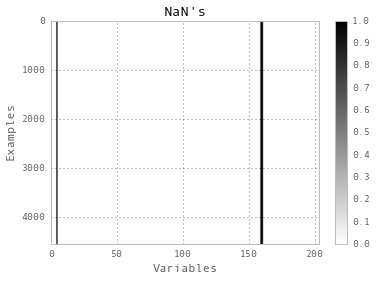

In [23]:
visualizeNaNs(df)

If we wanted to mark the columns with strings (words), we need to slightly modify the code.

In [24]:
df[list(df.dtypes[df.dtypes=='object'].index)].head()

Metadata_Experiment Metadata_Experimenter Metadata_Set Metadata_Type
0               Exp27                   KHR      cvsp1_0           CYC
1               Exp27                   KHR      cvsp1_1           CYC
2               Exp27                   KHR      cvsp1_1           CYC
3               Exp27                   KHR      cvsp1_1           CYC
4               Exp27                   KHR      cvsp1_1           CYC

In [25]:
def visualizeNaNs_and_strings(data_frame, row_names='Examples', column_names='Variables',title="NaN's and Strings"):
    #data_frame_to_plt=data_frame.drop(list(df.dtypes[df.dtypes=='object'].index),axis=1)
    data_frame_to_plt=data_frame.copy()
    data_frame_to_plt.loc[:,tuple(df.dtypes[df.dtypes=='object'].index)]=np.nan
    data_frame_to_plt=data_frame_to_plt.isnull()
    plt.imshow(data_frame_to_plt.get_values(),aspect='auto',cmap='binary')
    plt.xlabel(column_names) #, verticalalignment ='top'
    plt.ylabel(row_names)
    plt.title(title)
    plt.colorbar()

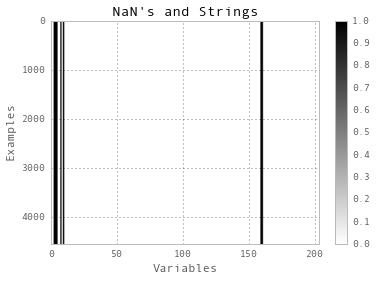

In [26]:
visualizeNaNs_and_strings(df)

So, there are three columns with NaN's and four columns with string variables. One of the string variables is a target variable for classifier.

In [27]:
df.shape

(4556, 203)

In [28]:
list(df.dtypes[df.dtypes=='object'].index)

['Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_Set',
 'Metadata_Type']

In [29]:
df_no_string=df.drop(list(df.dtypes[df.dtypes=='object'].index),axis=1)

In [30]:
df_no_string.shape

(4556, 199)

**Fourth**, we'll get all metadata columns. We can, of course use all the string data from above.

In [31]:
meta_data=[]
for col_name in df.columns:
    if re.match(r'.*(data).*', col_name) != None:
        meta_data.append(re.match(r'.*(data).*', col_name).group(0))

In [32]:
meta_data

['Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp']

In [33]:
[df.columns.tolist().index(col_meta) for col_meta in meta_data]

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [34]:
first_cols=df.columns.tolist()[0:2]

In [35]:
first_cols.reverse()

In [36]:
first_cols

['ObjectNumber', 'ImageNumber']

In [37]:
[meta_data.insert(0,col) for col in first_cols]

[None, None]

In [38]:
meta_data

['ImageNumber',
 'ObjectNumber',
 'Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp']

In [39]:
'''


import sys

col_file=open('../Data/columns_meta.txt','wb')

for col in meta_data:
    col_file.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file.close()
'''



ImageNumber
ObjectNumber
Metadata_Experiment
Metadata_Experimenter
Metadata_FileLocation
Metadata_Frame
Metadata_Series
Metadata_Set
Metadata_Treatment
Metadata_Type
Metadata_cvsp


The first two columns are also metadata. What about index 11 (12th column)?

In [40]:
len(meta_data)

11

In [41]:
df.columns[11], df.columns[12]

('AreaShape_Area', 'AreaShape_Center_X')

Looks like data column. However, these are columns that are  potentially irrelevant (unless you would like to look for **object location** biases). These are locators for objects detected within the image.

In [42]:
obj_locators=[]
obj_locators_ext=[]

for col in df.columns:
    if re.match('.*Center.*', col) !=None:
        obj_locators.append(re.match('.*Center.*', col).group())
    if re.match('.*Location.*', col) !=None:
        obj_locators_ext.append(re.match('.*Location.*', col).group())

In [43]:
obj_locators, obj_locators_ext

(['AreaShape_Center_X',
  'AreaShape_Center_Y',
  'Location_CenterMassIntensity_X_DNA',
  'Location_CenterMassIntensity_X_Rhodamine',
  'Location_CenterMassIntensity_Y_DNA',
  'Location_CenterMassIntensity_Y_Rhodamine',
  'Location_Center_X',
  'Location_Center_Y',
  'Mean_FilteredChromatin_AreaShape_Center_X',
  'Mean_FilteredChromatin_AreaShape_Center_Y',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine',
  'Mean_FilteredChromatin_Location_Center_X',
  'Mean_FilteredChromatin_Location_Center_Y'],
 ['Metadata_FileLocation',
  'Location_CenterMassIntensity_X_DNA',
  'Location_CenterMassIntensity_X_Rhodamine',
  'Location_CenterMassIntensity_Y_DNA',
  'Location_CenterMassIntensity_Y_Rhodamine',
  'Location_Center_X',
  'Location_Center_Y',
  'Location_MaxIntensity_X_DNA',
  'Lo

In [44]:
df.Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine.head(), df.Location_CenterMassIntensity_Y_Rhodamine.head()

(0    595
 1    204
 2    338
 3    503
 4    903
 Name: Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine, dtype: float64,
 0    603.693973
 1    209.206649
 2    328.424317
 3    532.346492
 4    917.485153
 Name: Location_CenterMassIntensity_Y_Rhodamine, dtype: float64)

In [45]:
'''


import sys

col_file_1=open('../Data/columns_obj_locators.txt','wb')
col_file_2=open('../Data/columns_obj_locators_ext.txt','wb')


for col in obj_locators:
    col_file_1.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file_1.close()
print
for col in obj_locators_ext:
    col_file_2.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file_2.close()

'''



AreaShape_Center_X
AreaShape_Center_Y
Location_CenterMassIntensity_X_DNA
Location_CenterMassIntensity_X_Rhodamine
Location_CenterMassIntensity_Y_DNA
Location_CenterMassIntensity_Y_Rhodamine
Location_Center_X
Location_Center_Y
Mean_FilteredChromatin_AreaShape_Center_X
Mean_FilteredChromatin_AreaShape_Center_Y
Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA
Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine
Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA
Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine
Mean_FilteredChromatin_Location_Center_X
Mean_FilteredChromatin_Location_Center_Y

Metadata_FileLocation
Location_CenterMassIntensity_X_DNA
Location_CenterMassIntensity_X_Rhodamine
Location_CenterMassIntensity_Y_DNA
Location_CenterMassIntensity_Y_Rhodamine
Location_Center_X
Location_Center_Y
Location_MaxIntensity_X_DNA
Location_MaxIntensity_X_Rhodamine
Location_MaxIntensity_Y_DNA
Location_MaxIntensity_Y_Rhodamine
Mean_FilteredChromatin_Locati

In [46]:
len(set(obj_locators)), len(obj_locators_ext), len(set(obj_locators+obj_locators_ext))

(16, 21, 25)

In [47]:
obj_locators_ext_set=set(obj_locators+obj_locators_ext)
to_remove=[]
for term in obj_locators_ext_set:
    if re.match('^Meta.*',term)!=None:
        to_remove.append(re.match('^Meta.*',term).group(0))
        print to_remove

for term in to_remove:
    obj_locators_ext_set.remove(term)
len(obj_locators_ext_set)

['Metadata_FileLocation']


24

In [48]:
'''


import sys

col_file_1=open('../Data/columns_obj_locators_ext_set.txt','wb')

for col in obj_locators_ext_set:
    col_file_1.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file_1.close()

'''



Location_Center_Y
Location_Center_X
Mean_FilteredChromatin_Location_Center_Y
Mean_FilteredChromatin_Location_Center_X
Mean_FilteredChromatin_AreaShape_Center_Y
Mean_FilteredChromatin_AreaShape_Center_X
AreaShape_Center_Y
AreaShape_Center_X
Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine
Location_CenterMassIntensity_Y_DNA
Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine
Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA
Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine
Location_CenterMassIntensity_Y_Rhodamine
Mean_FilteredChromatin_Location_MaxIntensity_X_DNA
Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA
Location_CenterMassIntensity_X_Rhodamine
Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA
Location_CenterMassIntensity_X_DNA
Location_MaxIntensity_X_DNA
Location_MaxIntensity_Y_DNA
Location_MaxIntensity_Y_Rhodamine
Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine
Location_MaxIntensity_X_Rhodamine


In [49]:
[df.columns.tolist().index(loc) for loc in obj_locators]

[12, 13, 90, 91, 92, 93, 94, 95, 111, 112, 190, 191, 192, 193, 194, 195]

In [50]:
df[obj_locators].head()

AreaShape_Center_X  AreaShape_Center_Y  Location_CenterMassIntensity_X_DNA  \
0                 768                 612                          775.558323   
1                 509                 203                          504.332805   
2                 921                 329                          920.725186   
3                 866                 533                          852.325446   
4                 391                 912                          389.609310   

   Location_CenterMassIntensity_X_Rhodamine  \
0                                777.270489   
1                                504.743594   
2                                923.217718   
3                                853.617364   
4                                390.945494   

   Location_CenterMassIntensity_Y_DNA  \
0                          604.844882   
1                          210.513326   
2                          329.617368   
3                          532.886342   
4                          918.086935   

   Location_CenterMassIntensity_Y_Rhodamine  Location_Center_X  \
0                                603.693973         777.794638   
1                                209.206649         504.524979   
2                                328.424317         924.749786   
3                                532.346492         854.078808   
4                                917.485153         389.464582   

   Location_Center_Y  Mean_FilteredChromatin_AreaShape_Center_X  \
0         603.334184                                        742   
1         209.014137                                        505   
2         329.136027                                        906   
3         532.612807                                        842   
4         917.284890                                        391   

   Mean_FilteredChromatin_AreaShape_Center_Y  \
0                                        604   
1                                        225   
2                                        340   
3                                        520   
4                                        946   

   Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA  \
0                                         773.923290           
1                                         506.514375           
2                                         913.605789           
3                                         843.111078           
4                                         387.634171           

   Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine  \
0                                         772.509043                 
1                                         504.636367                 
2                                         912.475064                 
3                                         845.119143                 
4                                         390.423672                 

   Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA  \
0                                         613.369269           
1                                         231.096636           
2                                         307.644805           
3                                         529.461395           
4                                         936.092267           

   Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine  \
0                                         613.284456                 
1                                         218.278124                 
2                                         316.177551                 
3                                         532.178965                 
4                                         925.178158                 

   Mean_FilteredChromatin_Location_Center_X  \
0                                775.805433   
1                                506.870355   
2                                914.427921   
3                                843.116935   
4                                387.579022   

  

Dropping object locators.

In [51]:
df_no_centers=df.drop(obj_locators,axis=1)

Worth considering: find **Euclidian distance** between the centers (Location_Center_X/Y and AreaShape_Center_X/Y) and use this as a variable.

In [52]:
df_no_centers.shape, df.shape

((4556, 187), (4556, 203))

In [53]:
def Euclidian_norm(x1,x2,y1,y2):
    a_sq=(np.abs(x1-x2))**2
    b_sq=(np.abs(y1-y2))**2
    c=np.sqrt(a_sq+b_sq)
    return c

In [54]:
Euclidian_norm(df.AreaShape_Center_X[0],df.Location_Center_X[0],df.AreaShape_Center_Y[0],df.Location_Center_Y[0])

13.077893451607723

In [55]:

df_no_centers['Euclidian_norm_centers']=Euclidian_norm(df.AreaShape_Center_X,df.Location_Center_X,df.AreaShape_Center_Y,df.Location_Center_Y)

Test below for normality (incl. transformed one).

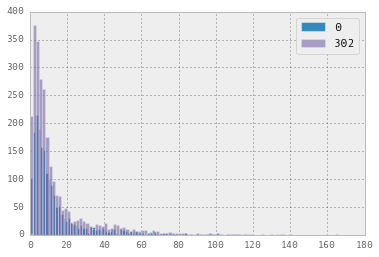

In [56]:
df_no_centers[df_no_centers.Metadata_Treatment==0].Euclidian_norm_centers.hist(bins=100)
df_no_centers[df_no_centers.Metadata_Treatment!=0].Euclidian_norm_centers.hist(bins=100, alpha=0.6)
plt.legend(('0','302'))

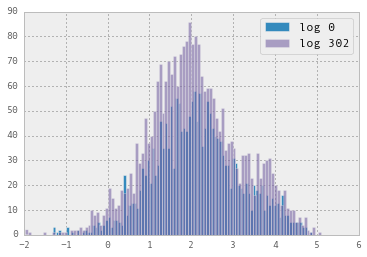

In [57]:
np.log(df_no_centers[df_no_centers.Metadata_Treatment==0].Euclidian_norm_centers).hist(bins=100)
np.log(df_no_centers[df_no_centers.Metadata_Treatment!=0].Euclidian_norm_centers).hist(bins=100, alpha=0.6)
plt.legend(('log 0','log 302'))

In [58]:
np.sum(df_no_centers.Metadata_Treatment==0), np.sum(df_no_centers.Metadata_Treatment!=0)

(1935, 2621)

In [59]:
df_no_centers.shape

(4556, 188)

In [60]:
df_no_centers.columns.tolist()

['ImageNumber',
 'ObjectNumber',
 'Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp',
 'AreaShape_Area',
 'AreaShape_Compactness',
 'AreaShape_Eccentricity',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'AreaShape_Zernike_0_0',
 'AreaShape_Zernike_1_1',
 'AreaShape_Zernike_2_0',
 'AreaShape_Zernike_2_2',
 'AreaShape_Zernike_3_1',
 'AreaShape_Zernike_3_3',
 'AreaShape_Zernike_4_0',
 'AreaShape_Zernike_4_2',
 'AreaShape_Zernike_4_4',
 'AreaShape_Zernike_5_1',
 'AreaShape_Zernike_5_3',
 'AreaShape_Zernike_5_5',
 'AreaShape_Zernike_6_0',
 'AreaShape_Zernike

Are the two distributions different? (control and with TPX2 added)


In [61]:
%R -i df_no_centers

In [62]:
%%R
head(df_no_centers)
class(df_no_centers)
print(dim(df_no_centers[df_no_centers$Metadata_Treatment==0,]))
print(dim(df_no_centers[df_no_centers$Metadata_Treatment!=0,]))
print(table(df_no_centers$Metadata_Treatment))
print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,mean,na.omit=TRUE))
print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,var))

print('log transformed: ')
print(names((tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,log,simplify=TRUE))))



print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,mean,na.omit=TRUE))
print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,var))

[1] 1935  188
[1] 2621  188

   0  302 
1935 2621 
       0      302 
14.20747 14.21875 
       0      302 
305.7277 345.9092 
[1] "log transformed: "
[1] "0"   "302"
       0      302 
14.20747 14.21875 
       0      302 
305.7277 345.9092 



	Two-sample Kolmogorov-Smirnov test

data:  df_no_centers[df_no_centers$Metadata_Treatment == 0, ]$Euclidian_norm_centers and df_no_centers[df_no_centers$Metadata_Treatment != 0, ]$Euclidian_norm_centers
D = 0.046607, p-value = 0.01587
alternative hypothesis: two-sided



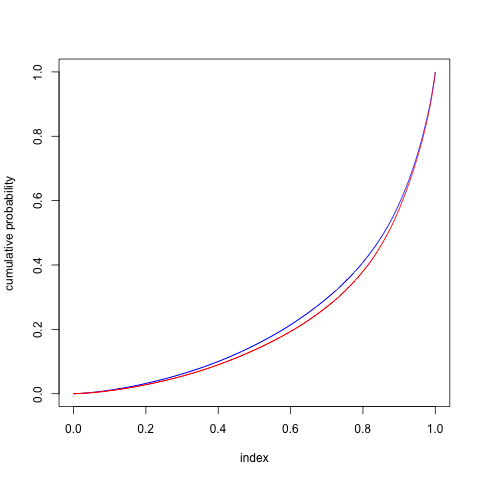

In [63]:
%%R
C=df_no_centers[df_no_centers$Metadata_Treatment==0,]$Euclidian_norm_centers
E=df_no_centers[df_no_centers$Metadata_Treatment!=0,]$Euclidian_norm_centers
plot(seq(0,1,length=length(C)), cumsum(sort(C)/sum(C)),type='l',col='blue',ylab='cumulative probability',xlab='index')
lines( seq(0,1,length=length(E)), cumsum(sort(E)/sum(E)), col='red')

print(ks.test(df_no_centers[df_no_centers$Metadata_Treatment==0,]$Euclidian_norm_centers,df_no_centers[df_no_centers$Metadata_Treatment!=0,]$Euclidian_norm_centers,))

In [64]:
%%R
class(as.numeric(C))

[1] "numeric"


In [65]:
%%R
source('skew.R')
print(skew(C))
print(skew(log(C)))
print(skew(sqrt(C)))



#print(hist(C))

 p.value     skew 
0.000000 2.714273 
   p.value       skew 
0.25726747 0.03630151 
p.value    skew 
0.00000 1.43945 


A set of variables that usually perform great when building a classifier, but not the easiest to interpret when selecting features, are **Zernike moments/polynomials**. We will specify them, so that we can compare model preformance with and without them.

In [66]:
Zernike_data=[]
for var in df.columns:
    if re.match('.*Zernike.*',var) != None:
        Zernike_data.append(re.match('.*Zernike.*',var).group(0))

Let's put it all together. For now, we want to drop all **'Meta'** columns, all **'locator'** columns and all **'NA'** columns. We will keep the **Euclidian distance** for now, as well as the **Zernike polynomials**. 

In [67]:
meta_data.extend(obj_locators)
meta_data.extend(NAs)

In [68]:
to_drop=list(set(meta_data))

In [69]:
to_drop

['Location_Center_Y',
 'Location_Center_X',
 'Mean_FilteredChromatin_Location_Center_Y',
 'Mean_FilteredChromatin_Location_Center_X',
 'Mean_FilteredChromatin_AreaShape_Center_Y',
 'Mean_FilteredChromatin_AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_Center_X',
 'Metadata_FileLocation',
 'Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine',
 'Location_CenterMassIntensity_Y_DNA',
 'ImageNumber',
 'Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine',
 'Metadata_cvsp',
 'Location_CenterMassIntensity_Y_Rhodamine',
 'Metadata_Experiment',
 'Metadata_Frame',
 'Mean_FilteredChromatin_Distance_Minimum_FilteredSpindles',
 'Metadata_Series',
 'Metadata_Experimenter',
 'Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA',
 'Mean_FilteredChromatin_Distance_Centroid_FilteredSpindles',
 'Location_CenterMassIntensity_X_DNA',
 'Metadata_Type',
 'Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA',
 'ObjectNumber',
 'Metadata_Treatment',
 'Location_Cent

In [70]:
df.shape

(4556, 203)

In [71]:
df_cont=df.drop(to_drop,axis=1)

In [72]:
df_cont.shape

(4556, 174)

In [73]:
#df_cont.to_csv('../Data/TPX2_df_with_Zernike.csv')

Changing the **target** variable encoding.

In [74]:
map_dict=dict(zip(list(np.unique(df['Metadata_Treatment'])),[0,1]))

In [75]:
map_dict

{0: 0, 302: 1}

In [76]:
df_cont['Metadata_Treatment']=df['Metadata_Treatment'].map(map_dict)

In [77]:
df_cont.shape

(4556, 175)

In [78]:
np.unique(df_cont['Metadata_Treatment'])

array([0, 1])

In [79]:
Y_binary=df_cont[df_cont.columns[-1]]

In [80]:
%R -i Y_binary

##IIb. Testing for normality

A number of variables show non-normal distribution. Some of them might be a mixture of Gaussians, though.

In [81]:
%R -i df_cont

In [82]:
%%R
apply(df_cont, 2, var, na.rm=TRUE)
apply(df_cont, 2, mean, na.rm=TRUE)
apply(df_cont, 2, sd, na.rm=TRUE)
sort(apply(df_cont,2, function(x){(sd(x)/abs(mean(x)))*100}))

print(sum(sort(apply(df_cont, 2, function(x){ks.test(x, 'pnorm',mean(x), sd(x))$p.value}))>0.1))
print(sum(sort(apply(df_cont, 2, function(x){ks.test(log(x), 'pnorm',mean(log(x)), sd(log(x)))$p.value}))>0.1))
print(sum(sort(apply(df_cont, 2, function(x){ks.test(sqrt(x), 'pnorm',mean(sqrt(x)), sd(sqrt(x)))$p.value}))>0.1))




print('1')
print(sort(apply(df_cont, 2, function(x){ks.test(x, 'pnorm',mean(x), sd(x))$p.value})))
print('2')
print(sort(apply(df_cont, 2, function(x){ks.test(log(x), 'pnorm',mean(log(x)), sd(log(x)))$p.value})))
print('3')
print(sort(apply(df_cont, 2, function(x){ks.test(sqrt(x), 'pnorm',mean(sqrt(x)), sd(sqrt(x)))$p.value})))


#hist(df_cont$AreaShape_Orientation,bins=100) #looks like uniform - try inverse tranform
#hist(log(abs(df_cont$Mean_FilteredChromatin_AreaShape_EulerNumber+1)))
#hist(sqrt(df_cont$AreaShape_Zernike_5_1))
#ks.test(sqrt(df_cont$AreaShape_Zernike_5_1),'pnorm',mean(sqrt(df_cont$AreaShape_Zernike_5_1)),sd(sqrt(df_cont$AreaShape_Zernike_5_1)))
#qqnorm(sqrt(df_cont$AreaShape_Zernike_5_1))
#qqnorm(log(df_cont$AreaShape_Zernike_5_1))
#qqnorm(df_cont$AreaShape_Zernike_5_1)

[1] 2
[1] 0
[1] 22
[1] "1"
                                                    AreaShape_Area 
                                                      0.000000e+00 
                                             AreaShape_Compactness 
                                                      0.000000e+00 
                                            AreaShape_Eccentricity 
                                                      0.000000e+00 
                                             AreaShape_EulerNumber 
                                                      0.000000e+00 
                                                  AreaShape_Extent 
                                                      0.000000e+00 
                                         AreaShape_MajorAxisLength 
                                                      0.000000e+00 
                                        AreaShape_MaxFeretDiameter 
                                                      0.000000e+00 
                     


	One-sample Kolmogorov-Smirnov test

data:  sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)
D = 0.14364, p-value < 2.2e-16
alternative hypothesis: two-sided



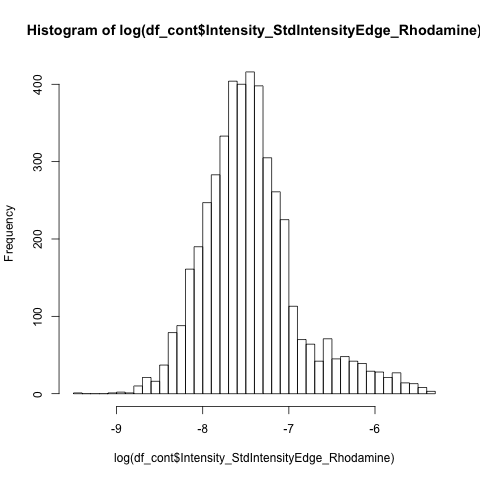

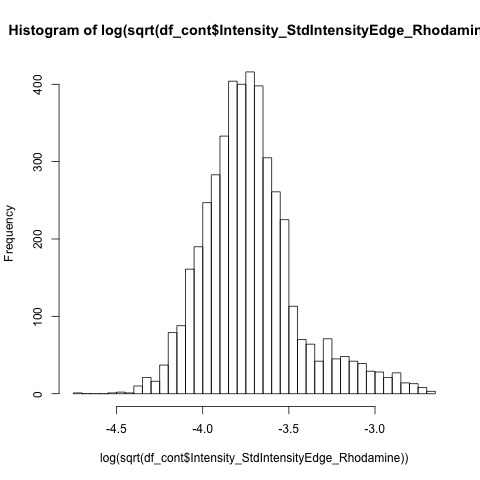

In [83]:
%%R
hist(log(df_cont$Intensity_StdIntensityEdge_Rhodamine),breaks=50)
hist(log(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)),breaks=50)
ks.test(log(df_cont$Intensity_StdIntensityEdge_Rhodamine),'pnorm',mean(log(df_cont$Intensity_StdIntensityEdge_Rhodamine)),sd(log(df_cont$Intensity_StdIntensityEdge_Rhodamine)))
ks.test(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine),'pnorm',mean(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)),sd(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)))

In [84]:
%%R
source('skew.R')
source('kurtosis.R')
print(dim(df_cont))
#print(grep('Meta', names(df_cont),value=TRUE ))
#print(names(df_cont)[! names(df_cont) %in% grep('Meta', names(df_cont),value=TRUE )])
apply(df_cont, 2, function(x){skew(x)[1]})

[1] 4556  175
                                                    AreaShape_Area 
                                                      0.000000e+00 
                                             AreaShape_Compactness 
                                                      0.000000e+00 
                                            AreaShape_Eccentricity 
                                                      1.000000e+00 
                                             AreaShape_EulerNumber 
                                                               NaN 
                                                  AreaShape_Extent 
                                                      1.000000e+00 
                                              AreaShape_FormFactor 
                                                      1.000000e+00 
                                         AreaShape_MajorAxisLength 
                                                      0.000000e+00 
                                  

##IIc. Detecting collinearity

One way to detect collinearity is through the use of variance inflation factor, [VIF](http://www.how2stats.net/2011/09/tolerance.html) 1/(1-Rsq), which is a reciprocal of [tolerance/coeffincient of alienation](http://www.how2stats.net/2011/09/tolerance.html) (1-Rsq). The lower the VIF the better (the lower the multicollinearity). It indicates the magnitude of the inflation in the standard errors associated with a particular paramater estimate (weight) that is due to multicollinearity.

In [85]:
%R -i df_cont

In [86]:
%%R
#library(plyr)
print(unique(df_cont[,'Metadata_Treatment']))

df_cont=as.data.frame(df_cont)
print(class(df_cont[,1]))
print(unique(df_cont$Metadata_Treatment))
convert_data_type=function(data_frame){

    for (col in names(data_frame)){
        data_frame[,col]<-as.numeric(data_frame[,col])
    }
    
    return(data_frame)
}

df_cont=convert_data_type(df_cont)
print(class(df_cont[,1]))

#df_cont$Metadata_Treatment=as.character(df_cont$Metadata_Treatment)
#print(class(df_cont$Metadata_Treatment))
#df_cont$Metadata_Treatment=as.factor(df_cont$Metadata_Treatment)
#print(class(df_cont$Metadata_Treatment))
#transform(df_cont, as.numeric(df.cont[,]))
str(df_cont$Metadata_Treatment)
head(df_cont$Metadata_Treatmen)

[1] 0 1
[1] "array"
[1] 0 1
[1] "numeric"
 num [1:4556] 0 0 0 0 0 0 0 0 0 0 ...
[1] 0 0 0 0 0 0


In [87]:
%%R
print(dim(df_cont))
print(dim(head(df_cont[,-length(names(df_cont))])))
print(dim(head(df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))])))
TPX2.original.names.corrs=names(df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))])
print(length(TPX2.original.names.corrs))
#write.csv(TPX2.original.names.corrs,file='../Data/TPX2_rcorr_all_P_adj_bonf_005_df_names.csv')
df_cont.cp=df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))]
print(names(df_cont.cp))
names(df_cont.cp)=seq(1,dim(head(df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))]))[2],1)


[1] 4556  175
[1]   6 174
[1]   6 173
[1] 173
  [1] "AreaShape_Area"                                                    
  [2] "AreaShape_Compactness"                                             
  [3] "AreaShape_Eccentricity"                                            
  [4] "AreaShape_Extent"                                                  
  [5] "AreaShape_FormFactor"                                              
  [6] "AreaShape_MajorAxisLength"                                         
  [7] "AreaShape_MaxFeretDiameter"                                        
  [8] "AreaShape_MaximumRadius"                                           
  [9] "AreaShape_MeanRadius"                                              
 [10] "AreaShape_MedianRadius"                                            
 [11] "AreaShape_MinFeretDiameter"                                        
 [12] "AreaShape_MinorAxisLength"                                         
 [13] "AreaShape_Orientation"                         

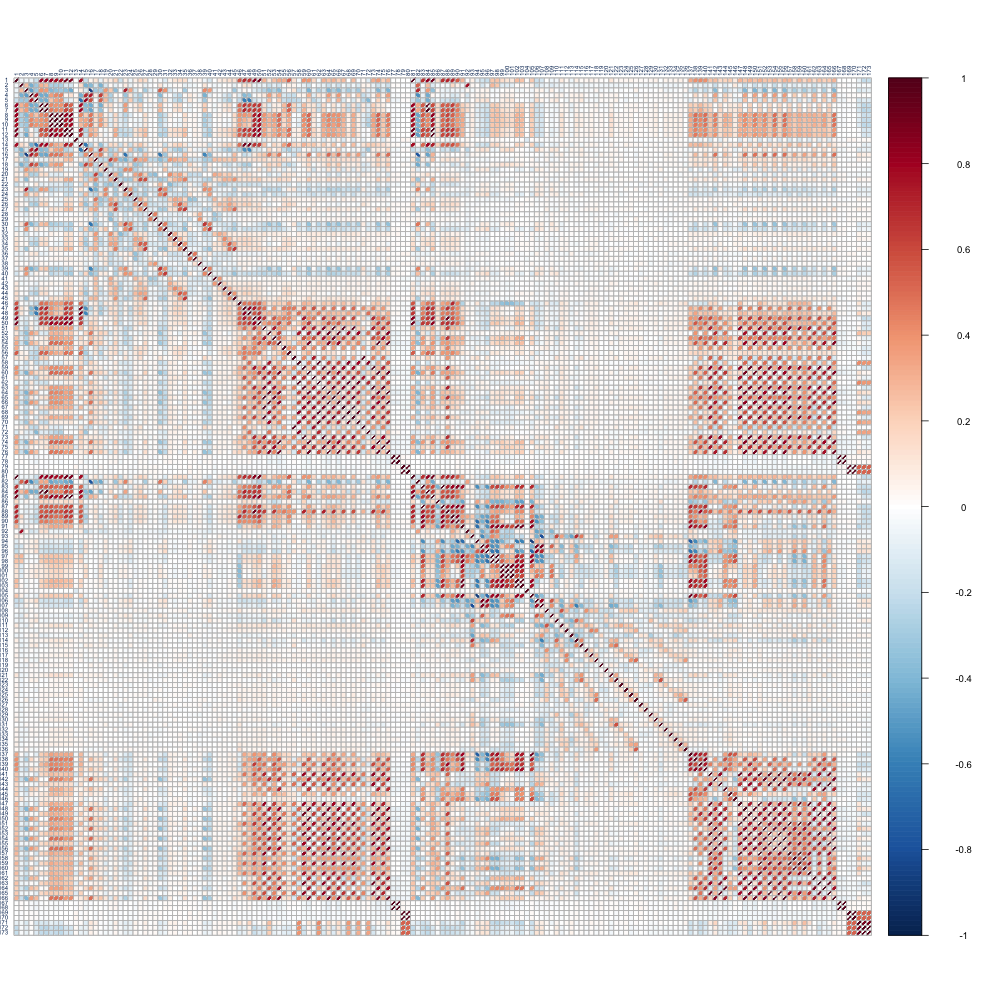

In [88]:
%%R -w 1000 -h 1000 -u px
library(corrplot)
corr.all=cor(df_cont.cp)
col2 <- colorRampPalette(rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061")))


#corr.all
png('../Plots/TPX2_rcorr_plot.png',width=2000, height=2000)
par(cex=0.8)
corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
dev.off()
corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)


In [89]:
%%R
names(df_cont.cp)

  [1] "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11"  "12" 
 [13] "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23"  "24" 
 [25] "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35"  "36" 
 [37] "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47"  "48" 
 [49] "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59"  "60" 
 [61] "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71"  "72" 
 [73] "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83"  "84" 
 [85] "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95"  "96" 
 [97] "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107" "108"
[109] "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119" "120"
[121] "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131" "132"
[133] "133" "134" "135" "136" "137" "138" "139" "140" "141" "142" "143" "144"
[145] "145" "146" "147" "148" "149" "150" "151" "152" "153" "154

In [90]:
%%R
class(corr.all)
#save(corr.all,file='../Data/TPX2_correlations_all.Robj')
#save(df_cont.cp, file='../Data/TPX2_df_cont.cp.Robj')

[1] "matrix"


Above we can see our complete correlation matrix. Clearly, there is quite some positive correlation among explanatory variables (and some negative). Easiest way to identify the correlations is by sorting the r values and assigning p-value to quantify the effect size. For selection of significant features, we will use **FDR (Benjamini-Hochberg)** correction for multiple comparisons.

In [91]:
%%R
library(Hmisc)
library(reshape)
rcorr.all=rcorr(as.matrix(df_cont.cp)) #has to be a matrix
#print(str(rcorr.all))


#print(dim((rcorr.all$P)))
print(head(rcorr.all$P[1:5,1:5]))
rcorr.all.P=as.vector(matrix(rcorr.all$P,dim(rcorr.all$P)[1]*dim(rcorr.all$P)[1],1)) #linearize matrix
rcorr.all.P.adj=p.adjust(rcorr.all.P,method='BH')
#print(head(rcorr.all.P))
rcorr.all.P.adj=matrix(rcorr.all.P.adj,dim(rcorr.all$P)[1],dim(rcorr.all$P)[2])
print(dim(rcorr.all.P.adj))
print(head(rcorr.all.P.adj[1:5,1:5]))

print(173*173)
#rcorr.all$P[order(rcorr.all$P[,1]),]

print(head(which(rcorr.all$P <= 0.05, arr.ind=TRUE),10L))
print(dim(which(rcorr.all$P<=1,arr.ind=TRUE))) #total number of comparisons

print(dim(which(rcorr.all$P<=0.05,arr.ind=TRUE)))
print(dim(which(rcorr.all$P<=0.01,arr.ind=TRUE)))

print(dim(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)))

Loading required package: grid
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

             1           2            3            4  5
1           NA 0.002480623 0.0003731284 1.792504e-06  0
2 2.480623e-03          NA 0.0000000000 0.000000e+00  0
3 3.731284e-04 0.000000000           NA 0.000000e+00  0
4 1.792504e-06 0.000000000 0.0000000000           NA  0
5 0.000000e+00 0.000000000 0.0000000000 0.000000e+00 NA
[1] 173 173
             [,1]        [,2]         [,3]         [,4] [,5]
[1,]           NA 0.004576725 0.0007393985 4.077811e-06    0
[2,] 4.576725e-03          NA 0.0000000000 0.000000e+00    0
[3,] 7.393985e-04 0.000000000           NA 0.000000e+00    0
[4,] 4.077811e-06 0.000000000 0.0000000000           NA    0
[5,] 0.000000e+00 0.000000000 0.0000000000 

In [92]:
%%R
print(dim(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)))
print(head(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)))

print(rcorr.all.P.adj[head(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE))])
rcorr.all.P.adj.BH.005=cbind(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE),rcorr.all.P.adj[which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)])
print(head(rcorr.all.P.adj.BH.005))


[1] 18848     2
     row col
[1,]   2   1
[2,]   3   1
[3,]   4   1
[4,]   5   1
[5,]   6   1
[6,]   7   1
[1] 4.576725e-03 7.393985e-04 4.077811e-06 0.000000e+00 0.000000e+00
[6] 0.000000e+00
     row col             
[1,]   2   1 4.576725e-03
[2,]   3   1 7.393985e-04
[3,]   4   1 4.077811e-06
[4,]   5   1 0.000000e+00
[5,]   6   1 0.000000e+00
[6,]   7   1 0.000000e+00


How many variables show correlation to other variables?

In [93]:
%%R
print(length(unique(rcorr.all.P.adj.BH.005[,1])))
correlating.regressors=matrix(unique(rcorr.all.P.adj.BH.005[,1]))
print(class(dim(rcorr.all.P.adj.BH.005[rcorr.all.P.adj.BH.005[,1]==4,])[1]))

no_of_corrs=vector('list',length=length(correlating.regressors))
#no_of_corrs <- numeric(length(correlating.regressors))
#print(class(no_of_corrs))
#print(head(no_of_corrs))
#print(length(no_of_corrs))
for (i in 1:dim(correlating.regressors)[1]) {
    #print(i)
    #print(no_of_corrs[i])
    no_of_corrs[[i]]=dim(rcorr.all.P.adj.BH.005[rcorr.all.P.adj.BH.005[,1]==correlating.regressors[i,1],])[1]
    #no_of_corrs[i] <- dim(rcorr.all.P.adj.005[rcorr.all.P.adj.005[,1]==correlating.regressors[i,1],])[1]
}
print(unlist(no_of_corrs))

cbind(correlating.regressors,unlist(no_of_corrs))

[1] 173
[1] "integer"
  [1] 131 124 107 128 123 124 137 139 138 140 142 131 114 113 119 116 118  87
 [19] 108 102 120 131  93  72 108  46 124 104  93  78 116  71  64 116 127  88
 [37]  82  99 113 145 134 136 141 144 144 120 138 143 129 126 125 110 133 140
 [55] 124 113 135 128 145 122 136 137  97 128 144 134 136 141 128 127 124 140
 [73] 112 127 141 140 137 117 106 115 127 135 115 113 127 134 135 112 111 122
 [91] 132 127 120 105 129  94 112  95  83 101  61  84  40  62  73  72  74  73
[109] 136 134 122 137 129 137 119 129 129 117 139 132 126 132 139 136 120 137
[127] 122 137 131 142 131 137 141 125 123 129 118 138 111 112 116 141 113  55
[145] 116 122 110 107 101  86  76  57  45  48  75  69  42  81  54  80  76  52
[163]  48  30  28  34  31  51  31  40  23  37  30
       [,1] [,2]
  [1,]    2  131
  [2,]    3  124
  [3,]    4  107
  [4,]    5  128
  [5,]    6  123
  [6,]    7  124
  [7,]    8  137
  [8,]    9  139
  [9,]   10  138
 [10,]   11  140
 [11,]   12  142
 [12,]   14  131
 [13,

Looks like all of them to some extent correlate with something else. Even the p-adjusted correlation matrix shows a lot of possible correlations. FDR, however is not too stringent. Let's try **Bonferroni** (procedure is exactly the same, just loaded into one cell).

In [94]:
%%R
#1
print('original p-value matrix:')
print(head(rcorr.all$P[1:5,1:5]))

rcorr.all.P.adj.bonf=p.adjust(rcorr.all.P,method="bonferroni")
rcorr.all.P.adj.bonf=matrix(rcorr.all.P.adj.bonf,dim(rcorr.all$P)[1],dim(rcorr.all$P)[2])

print(dim(rcorr.all.P.adj.bonf))

print('adjusted p-value matrix:')
print(head(rcorr.all.P.adj.bonf[1:5,1:5]))

#2
print(dim(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)))
print('indices for the significant cells:')
print(head(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)))
print('p-values:')
print(rcorr.all.P.adj.bonf[head(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE))])
print('indices for the significant cells with p-values: ')
rcorr.all.P.adj.bonf.005=cbind(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE),rcorr.all.P.adj.bonf[which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)])
print(head(rcorr.all.P.adj.bonf.005,20L))

#3
print(length(unique(rcorr.all.P.adj.bonf.005[,1])))
correlating.regressors.bonf=matrix(unique(rcorr.all.P.adj.bonf.005[,1]))

no_of_corrs.bonf=vector('list',length=length(correlating.regressors.bonf))
for (i in 1:dim(correlating.regressors.bonf)[1]) {
    no_of_corrs.bonf[[i]]=dim(rcorr.all.P.adj.bonf.005[rcorr.all.P.adj.bonf.005[,1]==correlating.regressors.bonf[i,1],])[1]
}
print(unlist(no_of_corrs.bonf))

cbind(correlating.regressors.bonf,unlist(no_of_corrs.bonf))



[1] "original p-value matrix:"
             1           2            3            4  5
1           NA 0.002480623 0.0003731284 1.792504e-06  0
2 2.480623e-03          NA 0.0000000000 0.000000e+00  0
3 3.731284e-04 0.000000000           NA 0.000000e+00  0
4 1.792504e-06 0.000000000 0.0000000000           NA  0
5 0.000000e+00 0.000000000 0.0000000000 0.000000e+00 NA
[1] 173 173
[1] "adjusted p-value matrix:"
           [,1] [,2] [,3]       [,4] [,5]
[1,]         NA    1    1 0.05333776    0
[2,] 1.00000000   NA    0 0.00000000    0
[3,] 1.00000000    0   NA 0.00000000    0
[4,] 0.05333776    0    0         NA    0
[5,] 0.00000000    0    0 0.00000000   NA
[1] 13060     2
[1] "indices for the significant cells:"
     row col
[1,]   5   1
[2,]   6   1
[3,]   7   1
[4,]   8   1
[5,]   9   1
[6,]  10   1
[1] "p-values:"
[1] 0 0 0 0 0 0
[1] "indices for the significant cells with p-values: "
      row col             
 [1,]   5   1 0.000000e+00
 [2,]   6   1 0.000000e+00
 [3,]   7   1 0.00000

Let's visualize Bonferroni corrected p-values.    
Corrplot does not have automatic functionality to deal with NAs, as these are values we don't care about (insignificant), we will re-code them into 1.0 here. 

In [95]:
%%R
rcorr.all.P.adj.bonf.noNA=rcorr.all.P.adj.bonf
rcorr.all.P.adj.bonf.noNA[is.na(rcorr.all.P.adj.bonf)==TRUE]=1.0
print(min(rcorr.all.P.adj.bonf.noNA))
print(max(rcorr.all.P.adj.bonf.noNA))
#max(-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))[-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))!=12])
print(min(-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))[-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))!=12]))
rcorr.all.negLog.P.adj.bonf.noNA=-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))

[1] 0
[1] 1
[1] -4.343331e-13


Below: the darker the field, the more significant the correlation.

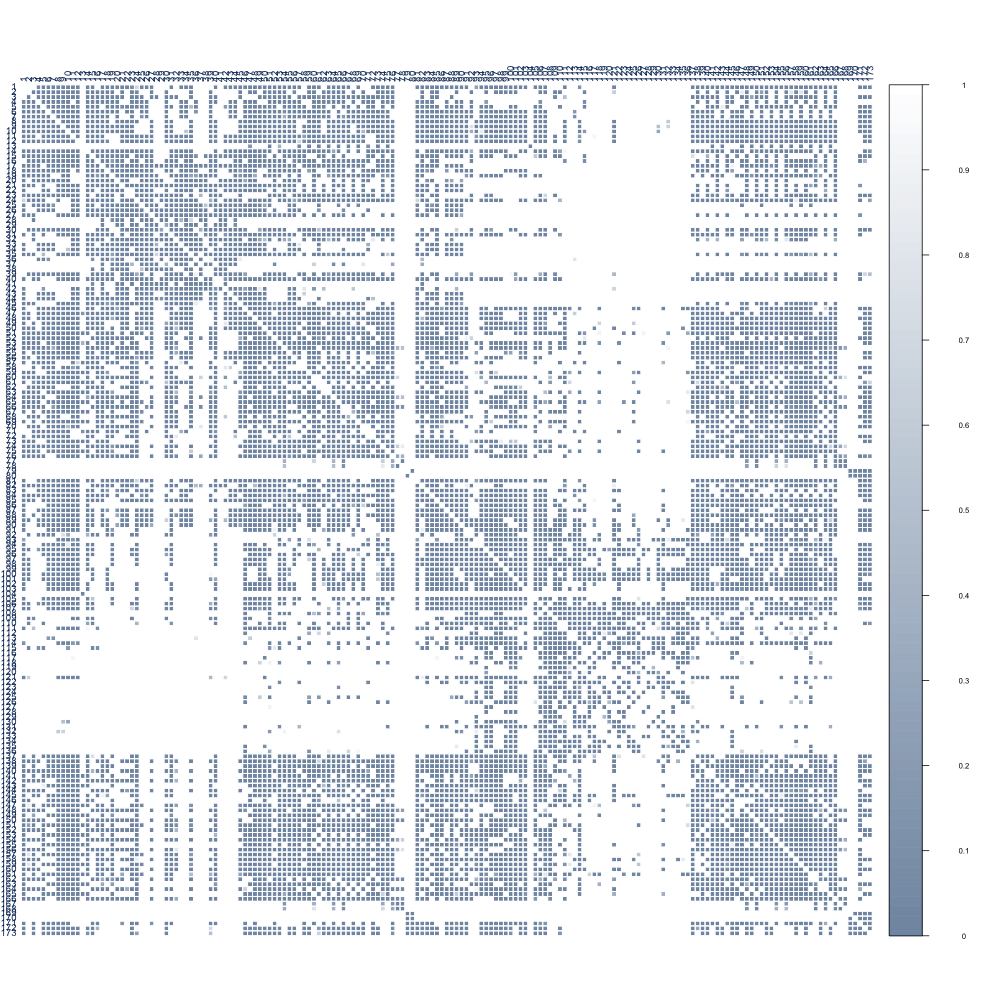

In [96]:
%%R -w 1000 -h 1000 -u px
library(corrplot)

col3 <- colorRampPalette(c("#053061",  "white"))

#corr.all
#png('../Data/TPX2_rcorr_plot.png',width=2000, height=2000)
par(cex=0.8)
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
#dev.off()
corrplot(rcorr.all.P.adj.bonf.noNA,is.corr = FALSE,method='shade', col=col3(dim(rcorr.all.P.adj.bonf.noNA)[2]),cl.lim=c(0,1),tl.col="#053061")



Below: the darker the field, the more significant the correlation. 

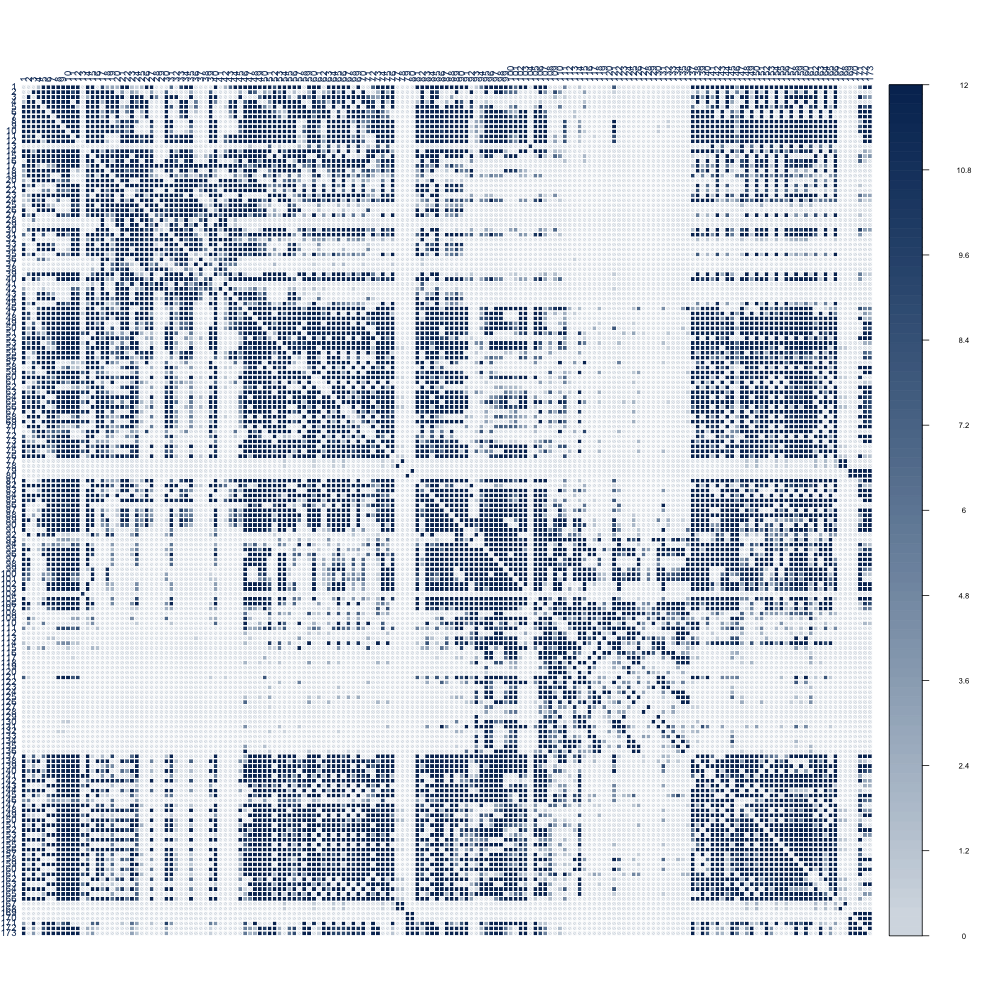

In [97]:
%%R -w 1000 -h 1000 -u px
library(corrplot)

col3 <- colorRampPalette(c( "white",'#D5DCE4',"#053061"))

#corr.all
#png('../Data/TPX2_rcorr_plot.png',width=2000, height=2000)
par(cex=0.8)
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
#dev.off()
corrplot(rcorr.all.negLog.P.adj.bonf.noNA,is.corr = FALSE,method='shade', col=col3(dim(rcorr.all.negLog.P.adj.bonf.noNA)[2]),cl.lim=c(-4.343331e-13,12),tl.col="#053061")

To make the output useful, we need to pull all the corellating regressors and associated p-values and sort them. We should get the strongest correlations. 

In [98]:
%%R
rcorr.all.P.adj.bonf.005=cbind(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE),rcorr.all.P.adj.bonf[which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)])
print(head(rcorr.all.P.adj.bonf.005,20L))
print(head(rcorr.all.P.adj.bonf.005[order(rcorr.all.P.adj.bonf.005[,3]),],100L))
rcorr.all.P.adj.bonf.005.df=as.data.frame(rcorr.all.P.adj.bonf.005[order(rcorr.all.P.adj.bonf.005[,3]),])
names(rcorr.all.P.adj.bonf.005.df)=c('x_idx_a','x_idx_b','p-value')
head(rcorr.all.P.adj.bonf.005.df)
#write.csv(rcorr.all.P.adj.bonf.005.df,file='../Data/TPX2_rcorr_all_P_adj_bonf_005_df.csv')

      row col             
 [1,]   5   1 0.000000e+00
 [2,]   6   1 0.000000e+00
 [3,]   7   1 0.000000e+00
 [4,]   8   1 0.000000e+00
 [5,]   9   1 0.000000e+00
 [6,]  10   1 0.000000e+00
 [7,]  11   1 0.000000e+00
 [8,]  12   1 0.000000e+00
 [9,]  14   1 0.000000e+00
[10,]  15   1 0.000000e+00
[11,]  17   1 6.871446e-10
[12,]  18   1 2.502159e-03
[13,]  19   1 9.000021e-04
[14,]  20   1 9.104706e-03
[15,]  21   1 0.000000e+00
[16,]  22   1 0.000000e+00
[17,]  25   1 1.667636e-02
[18,]  26   1 0.000000e+00
[19,]  27   1 0.000000e+00
[20,]  31   1 2.034609e-07
       row col  
  [1,]   5   1 0
  [2,]   6   1 0
  [3,]   7   1 0
  [4,]   8   1 0
  [5,]   9   1 0
  [6,]  10   1 0
  [7,]  11   1 0
  [8,]  12   1 0
  [9,]  14   1 0
 [10,]  15   1 0
 [11,]  21   1 0
 [12,]  22   1 0
 [13,]  26   1 0
 [14,]  27   1 0
 [15,]  34   1 0
 [16,]  35   1 0
 [17,]  40   1 0
 [18,]  44   1 0
 [19,]  45   1 0
 [20,]  46   1 0
 [21,]  47   1 0
 [22,]  48   1 0
 [23,]  49   1 0
 [24,]  50   1 0
 [25,]  

Ultimately, all the plots above illustrate that there are multiple colinear features in the data matrix. We will explore several ways to compensate for that below. 

Let's try stepwise **VIF selection**. Below we define the null and maximal model. 

In [99]:
%%R
modelVIF.null=glm(Metadata_Treatment ~ 1, family=binomial, data=df_cont)
modelVIF.1=glm(Metadata_Treatment ~ ., family=binomial, data=df_cont)

In [100]:
%%R
#print(summary(modelVIF.null))
print(anova(modelVIF.null,modelVIF.1))
print(AIC(modelVIF.null,modelVIF.1))

Analysis of Deviance Table

Model 1: Metadata_Treatment ~ 1
Model 2: Metadata_Treatment ~ AreaShape_Area + AreaShape_Compactness + 
    AreaShape_Eccentricity + AreaShape_EulerNumber + AreaShape_Extent + 
    AreaShape_FormFactor + AreaShape_MajorAxisLength + AreaShape_MaxFeretDiameter + 
    AreaShape_MaximumRadius + AreaShape_MeanRadius + AreaShape_MedianRadius + 
    AreaShape_MinFeretDiameter + AreaShape_MinorAxisLength + 
    AreaShape_Orientation + AreaShape_Perimeter + AreaShape_Solidity + 
    AreaShape_Zernike_0_0 + AreaShape_Zernike_1_1 + AreaShape_Zernike_2_0 + 
    AreaShape_Zernike_2_2 + AreaShape_Zernike_3_1 + AreaShape_Zernike_3_3 + 
    AreaShape_Zernike_4_0 + AreaShape_Zernike_4_2 + AreaShape_Zernike_4_4 + 
    AreaShape_Zernike_5_1 + AreaShape_Zernike_5_3 + AreaShape_Zernike_5_5 + 
    AreaShape_Zernike_6_0 + AreaShape_Zernike_6_2 + AreaShape_Zernike_6_4 + 
    AreaShape_Zernike_6_6 + AreaShape_Zernike_7_1 + AreaShape_Zernike_7_3 + 
    AreaShape_Zernike_7_5 + AreaSha

In [101]:
%%R
print(names(summary(modelVIF.1)))
print(dim(summary(modelVIF.1)$coefficients))
print(summary(modelVIF.1))

print('***')
print(summary(modelVIF.1)$coefficients[,4][summary(modelVIF.1)$coefficients[,4]<0.001])
modelVIF_1_0_001<-as.data.frame(summary(modelVIF.1)$coefficients[,4][summary(modelVIF.1)$coefficients[,4]<0.001])
names(modelVIF_1_0_001)<-"P_lt_0_001"
#write.csv(modelVIF_1_0_001,file='../Data/modelVIF_1_0_001.csv')

print('**')
print(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.01) & (summary(modelVIF.1)$coefficients[,4]>0.001)])
modelVIF_1_0_01<-as.data.frame(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.01) & (summary(modelVIF.1)$coefficients[,4]>0.001)])
names(modelVIF_1_0_01)<-"P_lt_0_01"
#write.csv(modelVIF_1_0_01,file='../Data/modelVIF_1_0_01.csv')

print('*')
print(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.05) & (summary(modelVIF.1)$coefficients[,4]>0.01)])
modelVIF_1_0_05<-as.data.frame(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.05) & (summary(modelVIF.1)$coefficients[,4]>0.01)])
names(modelVIF_1_0_05)<-"P_lt_0_05"
#write.csv(modelVIF_1_0_05,file='../Data/modelVIF_1_0_05.csv')

print('.')
print(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.1) & (summary(modelVIF.1)$coefficients[,4]>0.05)])
modelVIF_1_0_1<-as.data.frame(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.1) & (summary(modelVIF.1)$coefficients[,4]>0.05)])
names(modelVIF_1_0_1)<-"P_lt_0_1"
#write.csv(modelVIF_1_0_1,file='../Data/modelVIF_1_0_1.csv')



 [1] "call"           "terms"          "family"         "deviance"      
 [5] "aic"            "contrasts"      "df.residual"    "null.deviance" 
 [9] "df.null"        "iter"           "deviance.resid" "coefficients"  
[13] "aliased"        "dispersion"     "df"             "cov.unscaled"  
[17] "cov.scaled"    
[1] 170   4

Call:
glm(formula = Metadata_Treatment ~ ., family = binomial, data = df_cont)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6667  -0.2306   0.0140   0.2773   3.4309  

Coefficients: (5 not defined because of singularities)
                                                                     Estimate
(Intercept)                                                         4.949e+00
AreaShape_Area                                                     -8.034e-06
AreaShape_Compactness                                               1.713e-01
AreaShape_Eccentricity                                             -5.496e-01
AreaShape_EulerNumber             

Word of caution. It actually takes a while to calculate vif for larger data set (i.e. large number of features). It also is quite a laborious process. We will, however, compare its outcome to the cross-validated lasso approach and decision tree method (both, far more efficient), to see whether they will arrive to pretty good approximation of this backward selection method.     
      
The first selection is a bulk selection.


In [102]:
%%R
library(HH)
print(dim(df_cont))

vif_selected=function(df, threshold=10){
  max_vif=500
  while (max_vif > threshold){
    vifs = vif(df)
    max_vif=max(vifs)
    print(vifs[vifs==max(vifs)])
    df=df[,names(df)[!names(df) %in% names(vifs[vifs==max(vifs)])]]
    
  }
  return(df)
}



Loading required package: latticeExtra
Loading required package: RColorBrewer

Attaching package: ‘latticeExtra’

The following object is masked from ‘package:ggplot2’:

    layer

Loading required package: multcomp
Loading required package: mvtnorm
Loading required package: TH.data
Loading required package: gridExtra
[1] 4556  175


In [103]:
%%R
dim(df_cont[,names(df_cont)[!names(df_cont) %in% c("Metadata_Treatment")]])
vifs.null=vif(df_cont[,names(df_cont)[!names(df_cont) %in% c("Metadata_Treatment")]])

print(vifs.null[vifs.null<10])
print(length(vifs.null[vifs.null<10]))
print(names(vifs.null[vifs.null<10]))

                                      AreaShape_EulerNumber 
                                                   1.999991 
                                           AreaShape_Extent 
                                                   4.773677 
                                      AreaShape_Orientation 
                                                   1.077622 
                                      AreaShape_Zernike_1_1 
                                                   4.836610 
                                      AreaShape_Zernike_2_2 
                                                   9.447845 
                                      AreaShape_Zernike_3_1 
                                                   4.936817 
                                      AreaShape_Zernike_3_3 
                                                   2.930751 
                                      AreaShape_Zernike_4_0 
                                                   3.373422 
                        

A number of features are shape related Zernike moments. Let's take them out to get the features they correlate with insted and compare model performance.

In [104]:
%%R
modelVIF.2=glm(Metadata_Treatment ~ ., family=binomial, data=df_cont[,c(names(vifs.null[vifs.null<10]),'Metadata_Treatment')])

In [105]:
%%R
print(AIC(modelVIF.null)) #null (total deviance)
print(AIC(modelVIF.1)) #max (all vars)
print(AIC(modelVIF.2)) #current (all above VIF=10 removed)

print(anova(modelVIF.1,modelVIF.2))

[1] 6214.272
[1] 2464.231
[1] 4565.651
Analysis of Deviance Table

Model 1: Metadata_Treatment ~ AreaShape_Area + AreaShape_Compactness + 
    AreaShape_Eccentricity + AreaShape_EulerNumber + AreaShape_Extent + 
    AreaShape_FormFactor + AreaShape_MajorAxisLength + AreaShape_MaxFeretDiameter + 
    AreaShape_MaximumRadius + AreaShape_MeanRadius + AreaShape_MedianRadius + 
    AreaShape_MinFeretDiameter + AreaShape_MinorAxisLength + 
    AreaShape_Orientation + AreaShape_Perimeter + AreaShape_Solidity + 
    AreaShape_Zernike_0_0 + AreaShape_Zernike_1_1 + AreaShape_Zernike_2_0 + 
    AreaShape_Zernike_2_2 + AreaShape_Zernike_3_1 + AreaShape_Zernike_3_3 + 
    AreaShape_Zernike_4_0 + AreaShape_Zernike_4_2 + AreaShape_Zernike_4_4 + 
    AreaShape_Zernike_5_1 + AreaShape_Zernike_5_3 + AreaShape_Zernike_5_5 + 
    AreaShape_Zernike_6_0 + AreaShape_Zernike_6_2 + AreaShape_Zernike_6_4 + 
    AreaShape_Zernike_6_6 + AreaShape_Zernike_7_1 + AreaShape_Zernike_7_3 + 
    AreaShape_Zernike_7_5 + 

In [106]:
%%R
sum(is.na(df_cont[,c(names(vifs.null[vifs.null<10]))]))

[1] 0


[1] 0


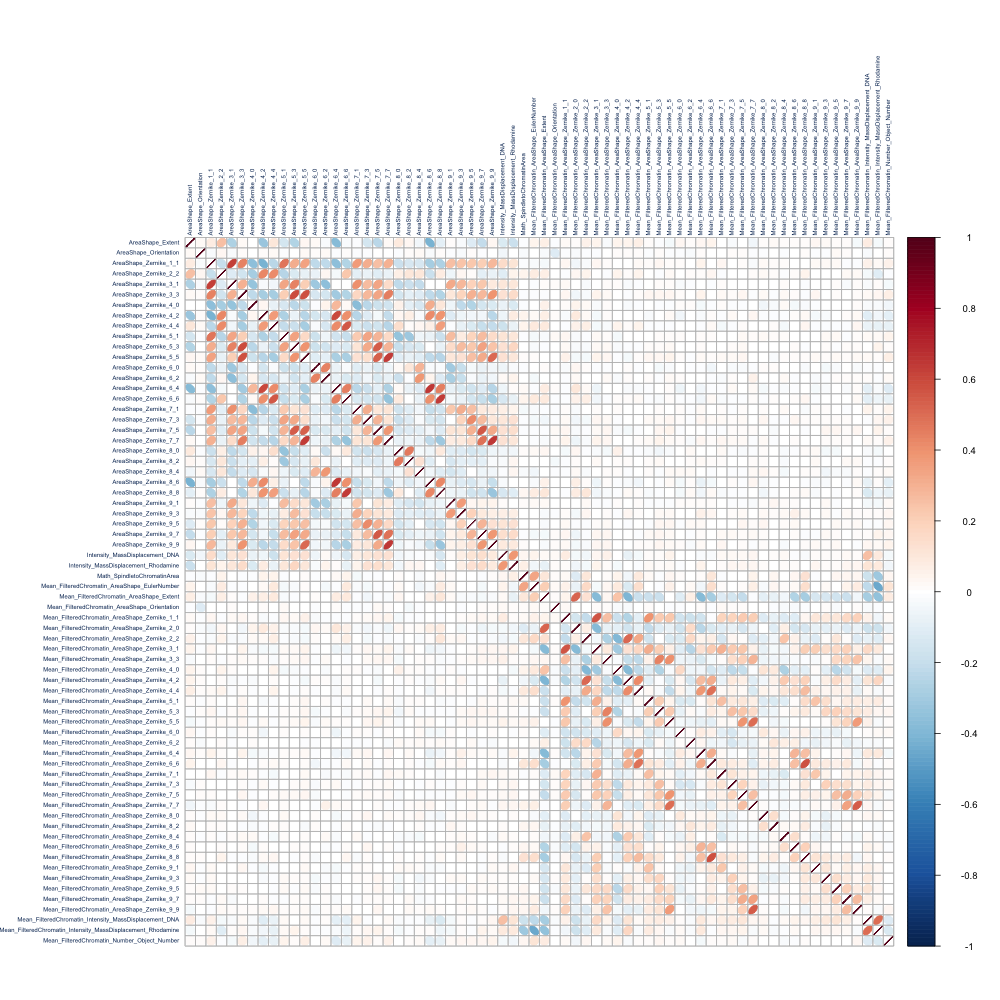

In [107]:
%%R -w 1000 -h 1000 -u px
library(corrplot)
to.test=df_cont[,c(names(vifs.null[vifs.null<10]))] 
to.test=to.test[,!names(to.test) %in% c('AreaShape_EulerNumber')]

corr.all=cor( to.test)
print(sum(is.na(corr.all)))
#which(is.na(corr.all),arr.ind=TRUE)

#col2 <- colorRampPalette(rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061")))


#corr.all
#png('../Data/TPX2_rcorr_plot.png',width=2000, height=2000)
#par(cex=0.8)
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
#dev.off()
corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)

Removal below is a bulk removal, which seems rather strict (leaves only 69 variables - plotted below).

In [108]:
%%R
df.1=df_cont[,names(df_cont)[!names(df_cont) %in% c("Metadata_Treatment")]] #all 
df.2=df.1[,names(df.1)[!names(df.1) %in% names(vifs.null[vifs.null==max(vifs.null)])]] #batch removal
vifs.1=vif(df.2)

In [109]:
#%%R 
#res=vif_selected(df.1, threshold=10)

In [110]:
%%R
#write.csv(df.1, file = '../Data/vif_sel_1.csv')
dim(df.1)

[1] 4556  174


The function below takes a while. Thus, it is packaged in an external R script (**vif_sel.R**). 

In [111]:
%%R
#df.backward.sel=vif_selected(df.1)

NULL


####a. decision trees
#####a.1. decision trees -R


In [112]:
%R -i meta_data

In [113]:
%%R
explanatory_all=df_no_centers[,!names(df_no_centers) %in% meta_data]
response=df_no_centers$Metadata_Treatment
resp_w_explanatory=data.frame(cbind(response,explanatory_all))

for (col in names(resp_w_explanatory)){
    print(class(resp_w_explanatory[,col]))
}
print('end of test 1')
for (col in names(resp_w_explanatory)){
    resp_w_explanatory[,col]=as.numeric(resp_w_explanatory[,col])
}

for (col in names(resp_w_explanatory)){
    print(class(resp_w_explanatory[,col]))
}
print('end of test 2')

print(class(resp_w_explanatory$response))
resp_w_explanatory$response=as.factor(as.character(resp_w_explanatory$response))
print(class(resp_w_explanatory$response))


[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] "array"
[1] 

In [114]:
%%R
library(tree)

tree.1=tree(response ~. , resp_w_explanatory)

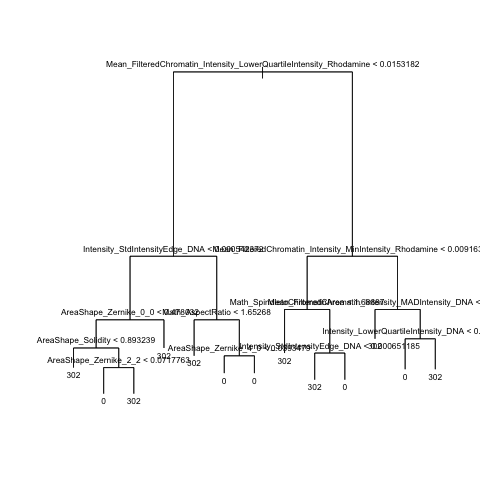

In [115]:
%%R
plot(tree.1)
text(tree.1,cex=0.7)

In [116]:
%%R
summary(tree.1)


Classification tree:
tree(formula = response ~ ., data = resp_w_explanatory)
Variables actually used in tree construction:
 [1] "Mean_FilteredChromatin_Intensity_LowerQuartileIntensity_Rhodamine"
 [2] "Intensity_StdIntensityEdge_DNA"                                   
 [3] "AreaShape_Zernike_0_0"                                            
 [4] "AreaShape_Solidity"                                               
 [5] "AreaShape_Zernike_2_2"                                            
 [6] "Math_AspectRatio"                                                 
 [7] "AreaShape_Zernike_4_0"                                            
 [8] "Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine"          
 [9] "Math_SpindletoChromatinArea"                                      
[10] "Mean_FilteredChromatin_Intensity_MADIntensity_DNA"                
[11] "Intensity_LowerQuartileIntensity_DNA"                             
Number of terminal nodes:  13 
Residual mean deviance:  0.8536 = 3878 / 4

What if we drop Zernike moments?

In [117]:
%%R
zernike=grep('Zernike',names(resp_w_explanatory),value=TRUE)
resp_w_explanatory_no_zernike=resp_w_explanatory[,!names(resp_w_explanatory) %in% zernike]
dim(resp_w_explanatory_no_zernike)

[1] 4556  116


In [118]:
%%R
tree.2=tree(response~., resp_w_explanatory_no_zernike)


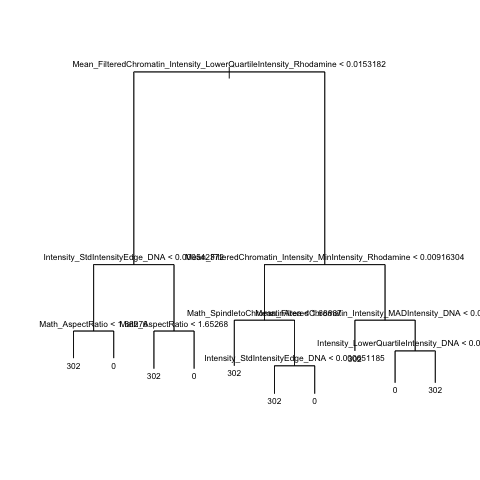

In [119]:
%%R
plot(tree.2)
text(tree.2,cex=0.7)


In [120]:
%%R
summary(tree.2)


Classification tree:
tree(formula = response ~ ., data = resp_w_explanatory_no_zernike)
Variables actually used in tree construction:
[1] "Mean_FilteredChromatin_Intensity_LowerQuartileIntensity_Rhodamine"
[2] "Intensity_StdIntensityEdge_DNA"                                   
[3] "Math_AspectRatio"                                                 
[4] "Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine"          
[5] "Math_SpindletoChromatinArea"                                      
[6] "Mean_FilteredChromatin_Intensity_MADIntensity_DNA"                
[7] "Intensity_LowerQuartileIntensity_DNA"                             
Number of terminal nodes:  10 
Residual mean deviance:  0.9131 = 4151 / 4546 
Misclassification error rate: 0.2065 = 941 / 4556 


#####a.2. decision trees - Python


In [121]:
df_no_centers['Metadata_Treatment']=df_no_centers['Metadata_Treatment'].apply(str)

In [122]:
type(df_no_centers['Metadata_Treatment'][0])

str

In [123]:
df_no_centers.Metadata_Treatment.dtype

dtype('O')

In [124]:
df_no_centers[['Metadata_Treatment']].dtypes

Metadata_Treatment    object
dtype: object

In [125]:
np.unique(df_no_centers[['Metadata_Treatment']])

array(['0', '302'], dtype=object)

In [126]:
explanatory_vars=df_no_centers[list((set(df_no_centers.columns).difference(set(meta_data))))]

In [127]:
explanatory_vars.shape

(4556, 175)

In [128]:
explanatory_vars['Metadata_Treatment']=df_no_centers['Metadata_Treatment']

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [129]:
explanatory_vars.shape

(4556, 176)

In [130]:
explanatory_vars.columns[-1]

'Metadata_Treatment'

In [131]:
from sklearn.ensemble import ExtraTreesClassifier
X=explanatory_vars.iloc[:,0:-1]
X=X.values
y=explanatory_vars.iloc[:, -1].values

In [132]:
X.shape, y.shape

((4556, 175), (4556,))

In [133]:
classifier=ExtraTreesClassifier()
X_new=classifier.fit(X,y).transform(X)

In [134]:
classifier.feature_importances_.shape, X_new.shape

((175,), (4556, 52))

In [135]:
feature_importance_value=classifier.feature_importances_

In [136]:
feature_importance_value.shape,explanatory_vars.columns[:-1].shape


((175,), (175,))

In [137]:
feature_importance_df=pd.DataFrame(np.array(zip(feature_importance_value,explanatory_vars.columns[:-1])))

In [138]:
feature_importance_df.sort(0,ascending=False)#.to_csv('tree_2.csv')

0                                                  1
40    0.0259814632019  Mean_FilteredChromatin_Intensity_MinIntensityE...
58    0.0257783985566                              AreaShape_Zernike_0_0
167   0.0222217848314  Mean_FilteredChromatin_Intensity_MinIntensity_...
94    0.0200430981266  Mean_FilteredChromatin_Intensity_MeanIntensity...
169   0.0199807151492  Mean_FilteredChromatin_Intensity_MeanIntensity...
133    0.019875007944                     Intensity_StdIntensityEdge_DNA
93    0.0198606119146                      Intensity_MedianIntensity_DNA
119   0.0190203583165  Mean_FilteredChromatin_Intensity_MedianIntensi...
118   0.0182574202533  Mean_FilteredChromatin_Intensity_LowerQuartile...
35    0.0159726727649                              AreaShape_Zernike_8_6
101   0.0155165000783  Mean_FilteredChromatin_Intensity_MedianIntensi...
87    0.0135103126287  Mean_FilteredChromatin_Intensity_MaxIntensity_...
24    0.0131812383064                              AreaShape_Zernike_4_2
156   0.0127789617648                   Intensity_MaxIntensity_Rhodamine
96    0.0126883390032               Intensity_LowerQuartileIntensity_DNA
151   0.0124434443547               Intensity_MaxIntensityEdge_Rhodamine
37    0.0107363676426                             AreaShape_Eccentricity
31    0.0105197636638         Intensity_UpperQuartileIntensity_Rhodamine
28     0.010512082265                              AreaShape_Zernike_8_8
125   0.0103878322601                     Intensity_MaxIntensityEdge_DNA
153   0.0102342980459                    Intensity_MeanIntensityEdge_DNA
26    0.0098495211941                              AreaShape_Zernike_4_0
6    0.00984393635677                              AreaShape_Zernike_6_4
163  0.00924750794961  Mean_FilteredChromatin_Intensity_MeanIntensity...
122  0.00919183525221              Intensity_MeanIntensityEdge_Rhodamine
99   0.00847914364746                              AreaShape_Zernike_1_1
17   0.00844425331182  Mean_FilteredChromatin_Intensity_MADIntensity_DNA
0    0.00839872576943  Mean_FilteredChromatin_Intensity_UpperQuartile...
23   0.00785120548365                              AreaShape_Zernike_4_4
16   0.00780974160056  Mean_FilteredChromatin_Intensity_IntegratedInt...
..                ...                                                ...
117  0.00294136739989       Mean_FilteredChromatin_AreaShape_Zernike_4_0
120  0.00293634268141  Mean_FilteredChromatin_Intensity_MaxIntensityE...
32    0.0029137389462                              AreaShape_Zernike_8_2
142  0.00291148775864       Mean_FilteredChromatin_AreaShape_Zernike_9_1
124  0.00291112547447       Mean_FilteredChromatin_AreaShape_Zernike_5_3
165  0.00290393225973                            Math_TotalChromatinArea
80   0.00290040477409                              AreaShape_Zernike_9_7
12   0.00288384375141       Mean_FilteredChromatin_AreaShape_Zernike_8_4
60   0.00285165544419       Mean_FilteredChromatin_AreaShape_Zernike_6_0
173  0.00284320190616                        Location_MaxIntensity_X_DNA
129  0.00279776265089       Mean_FilteredChromatin_AreaShape_Zernike_5_5
21   0.00277910836338  Mean_FilteredChromatin_Location_MaxIntensity_X...
89   0.00274173945161       Mean_FilteredChromatin_AreaShape_Zernike_2_0
75   0.00273117358772                              AreaShape_Zernike_5_1
15   0.00271923863791       Mean_FilteredChromatin_AreaShape_Zernike_8_2
103  0.00270473040767       Mean_FilteredChromatin_AreaShape_EulerNumber
70   0.00269389699047       Mean_FilteredChromatin_AreaShape_Zernike_8_0
148   0.0026774102965                             AreaShape_MedianRadius
25   0.00266667738592                              AreaShape_Zernike_6_2
104  0.00264833390457                  Location_MaxIntensity_X_Rhodamine
33   0.00264374538444       Mean_FilteredChromatin_AreaShape_Zernike_7_3
172  0.00259533080806                  Location_MaxIntensity_Y_Rhodamine
155  0.00258013847511  Mean_FilteredChromatin_Location_MaxIntensity_Y...
13   

####logistic regression with all features (L1-based)

In [139]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [140]:
explanatory_vars.head()

Mean_FilteredChromatin_Intensity_UpperQuartileIntensity_DNA  \
0                                           0.005325             
1                                           0.005783             
2                                           0.005676             
3                                           0.005249             
4                                           0.005463             

   Intensity_IntegratedIntensity_Rhodamine  Math_SpindletoChromatinArea  \
0                               233.423028                     1.766581   
1                               324.169408                     1.516671   
2                               298.168767                     0.777743   
3                               154.930924                     1.050426   
4                               187.232366                     1.580434   

   AreaShape_Zernike_6_0  Number_Object_Number  \
0               0.014511                     1   
1               0.003943                     1   
2               0.009712                     2   
3               0.020628                     3   
4               0.009570                     4   

   Mean_FilteredChromatin_AreaShape_Zernike_7_5  AreaShape_Zernike_6_4  \
0                                      0.010440               0.025778   
1                                      0.009423               0.023807   
2                                      0.012613               0.017810   
3                                      0.012957               0.025003   
4                                      0.012621               0.030376   

   AreaShape_Zernike_6_6  Mean_FilteredChromatin_AreaShape_MaximumRadius  \
0               0.014895                                       33.060551   
1               0.014323                                       44.045431   
2               0.009800                                       67.067131   
3               0.012542                                       38.327536   
4               0.014524                                       35.057096   

   AreaShape_Compactness         ...          \
0               1.543757         ...           
1               1.417695         ...           
2               1.509907         ...           
3               1.764074         ...           
4               1.496165         ...           

   Intensity_StdIntensityEdge_Rhodamine  \
0                              0.000247   
1                              0.000420   
2                              0.000323   
3                              0.000353   
4                              0.000292   

   Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine  \
0                                           0.003616         
1                                           0.003571         
2                                           0.003250         
3                                           0.003754         
4                                           0.003693         

   Intensity_StdIntensity_DNA  \
0                    0.000940   
1                    0.001124   
2                    0.001176   
3                    0.000940   
4                    0.000916   

   Mean_FilteredChromatin_Intensity_MeanIntensity_Rhodamine  \
0                                           0.011689          
1                                           0.017160          
2                                           0.010606          
3                                           0.010098          
4                                           0.013139          

   Mean_FilteredChromatin_AreaShape_Zernike_3_3  \
0                                      0.016528   
1                                      0.004675   
2                                      0.016938   
3                                      0.009448   
4                                      0.006366   

   Mean_FilteredChromatin_AreaShape_Zernike_3_1  \
0                                      0.018353   
1                                      0.015

In [141]:
X.shape, y.shape

((4556, 175), (4556,))

In [142]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2,random_state=0)

In [143]:
lr_model_1=LogisticRegression(penalty='l1',C=1)

In [144]:
lr_model_1.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)

In [145]:
y_pred_1=lr_model_1.predict(X_test)

In [146]:
accuracy_score(y_test,y_pred_1)

0.83333333333333337

In [147]:
np.sum(X_train>0)

632638

In [148]:
sklearn.feature_selection.univariate_selection.f_classif(X_train,y_train)

(array([  6.45500326e+01,   1.06232073e+02,   1.61170426e+00,
          1.84887362e-01,   3.48841325e+01,   3.81992885e+00,
          5.22414686e+02,   1.90025250e+02,   1.67905149e+01,
          2.08438060e+01,   3.60252985e+01,   7.87340672e+01,
          3.12493547e+00,   1.30588960e-01,   4.55021517e+00,
          1.26133505e+00,   2.23140519e+01,   1.24668252e+02,
          1.99043107e+01,   8.78632390e+01,   5.03381130e+00,
          3.64704161e-01,   1.49479320e+00,   5.63873353e+00,
          2.89501081e+02,   2.99395027e-01,   1.61438927e+02,
          2.07451671e+01,   4.19791250e+02,   1.12667598e+02,
          1.17220467e+01,   4.95067992e+02,   1.00768187e+01,
          3.07224622e+00,   2.13987432e-01,   6.79328151e+02,
          5.70465928e+00,   4.82235660e+02,   1.53726171e+00,
          4.52027383e+00,   7.06214400e+02,   1.53714680e+01,
          6.06979521e+01,   7.37646071e-02,   1.18145119e+02,
          1.01072474e+02,   6.56126671e+01,   5.47772534e-02,
        

####logistic regression upon PCA (L1-based)

In [149]:
df_pca=pd.read_csv('../Data/TPX2_PC_caret.csv')

In [150]:
df_pca.drop(df_pca.columns[0],axis=1,inplace=True)

In [151]:
df_pca.head()

PC1       PC2        PC3       PC4       PC5       PC6       PC7  \
0  2.123022  0.627802   8.848296  4.270302 -1.341878 -2.408985  0.245298   
1 -0.352771  2.599545   5.830215  6.915378  1.002481 -0.573486  0.658443   
2 -2.140023  2.176877  10.881352  5.401080  0.573965  4.319418  2.124379   
3  3.590060  0.421623   8.071970  3.866503 -0.958051  0.749666 -2.244507   
4  2.894119  1.173272   6.103281  2.725358  0.191903  0.462449 -1.490408   

        PC8       PC9      PC10    ...         PC55      PC56      PC57  \
0 -1.445948 -1.417229  0.453724    ...     0.381578 -1.620998 -0.629310   
1  2.217732 -0.727395 -0.411730    ...     1.210177 -1.323865 -1.566068   
2  0.051084  0.107367  1.775270    ...     0.618207  0.658964  0.887164   
3 -1.182668 -1.709022  1.342985    ...     0.607138 -0.426061  0.048024   
4 -3.715141  1.482562 -1.737706    ...    -0.134246  0.532787  0.011951   

       PC58      PC59      PC60      PC61      PC62      PC63      PC64  
0 -1.016260 -0.133544  0.640321 -1.191476 -0.024453 -0.141401  0.278294  
1 -0.725991 -0.099551 -0.369438 -0.414920  0.803804 -0.882296  0.215089  
2 -0.217094 -1.367357  0.702475  0.198614 -0.186393  1.202584 -0.686564  
3  0.391029 -0.118440  0.561557 -0.201504 -0.890588  0.402664 -0.080831  
4 -0.244908 -0.723648 -0.077769  0.198835 -0.705716  0.053979  0.264305  

[5 rows x 64 columns]

In [152]:
df_pca.shape

(4556, 64)

In [153]:
X=df_pca.values

In [154]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2,random_state=0)

In [155]:
lr_model_1=LogisticRegression(penalty='l1',C=1)

In [156]:
lr_model_1.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)

In [157]:
y_pred_1=lr_model_1.predict(X_test)

In [158]:
probs_ROC_1=lr_model_1.predict_proba(X_test)

In [159]:
accuracy_score(y_test,y_pred_1)

0.85197368421052633

In [160]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [161]:
roc_curve(target_test, probs_ROC_1[:, 1])

NameError: name 'target_test' is not defined

In [ ]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
   # plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
plot_roc_curve(y_test, probs_ROC_1)
plt.title('Receiver Operating Characteristic v.1')

####c. dropping features with low variance (as a fraction of mean) - see above (section IIa)

In [ ]:
df_no_centers[list((set(df_no_centers.columns).difference(set(meta_data))))].head()

In [ ]:
df_no_centers[list((set(df_no_centers.columns).difference(set(meta_data))))].describe()

#IV. Clustering

In [ ]:
from sklearn import preprocessing
from Bio.Cluster import *

In [ ]:
np.shape(df_cont)

In [ ]:
error_PC=[]
for i in xrange(2,100+1):
    clusterid,error,nfound=kmedoids(distance=distancematrix(array_for_cluster_scaled),nclusters=i,npass=10)
    error_PC.append((i, error))
plt.plot(error_PC)
plt.legend(['K','error'])

#V. Multidimensional scaling

#VI. Univariate feature analysis 

Analysis below repeats and slightly extends analysis reported in [Helmke and Heald, 2014](http://jcb.rupress.org/content/206/3/385.full). 

##Va. 

In [ ]:
import sys
for name in df_cont.columns:
    #print name
    sys.stdout.write(name+'\n')

In [ ]:
for name in df_cont.columns:
    if re.match('area', name, flags=re.I) !=None:
        print name

In [ ]:
%R -i df


In [ ]:
%R -i Y_binary

In [ ]:
%%R
hist(1/df[names(df)[grep('Aspect',names(df))]])
hist(df[names(df)[grep('Eccentricity',names(df))]])
hist(df[names(df)[grep('length',names(df),ignore.case=TRUE)]])



#hist(sqrt(df[names(df)[grep('Aspect',names(df))]]))
#hist(log(df[names(df)[grep('Aspect',names(df))]]))

In [ ]:
%%R
df['Y_binary']=Y_binary

In [ ]:
%%R
plot=ggplot(data=df)
plot+geom_violin(aes(factor(Metadata_Treatment),y=1/Math_AspectRatio,fill=factor(Metadata_Treatment)))+scale_fill_manual(values=c('#7F7F7F','#FBF70B'))+theme_bw()#+theme_update(panel.grid.minor=element_line(size=0.5))#+geom_jitter(aes(factor(Y_binary),y=1/Math_AspectRatio))
#ggsave(file='../Plots/TPX2_aspect_violin.pdf')

To save above as a **pdf** 

In [ ]:
%%R
plot=ggplot(data=df)
plot+geom_boxplot(aes(factor(Metadata_Treatment),y=1/Math_AspectRatio,fill=factor(Metadata_Treatment)))+scale_fill_manual(values=c('#7F7F7F','#FBF70B'))+theme_bw()#+geom_jitter(aes(factor(Y_binary),y=1/Math_AspectRatio))
#ggsave(file='../Plots/TPX2_aspect_boxplot.pdf')

In [ ]:
%%R
unique(df[,'Metadata_Type'])

In [ ]:
%%R
names(df_cont)
